In [ ]:
from google.colab import drive
from os.path import join  

def mount_drive(ROOT):
    drive.mount(ROOT, force_remount=True)

ROOT = '/content/drive'
mount_drive(ROOT)

MY_GOOGLE_DRIVE_PATH = 'MyDrive/RL_NLP/' 
PROJECT_PATH = join(ROOT, MY_GOOGLE_DRIVE_PATH)
print("PROJECT_PATH: ", PROJECT_PATH)   
%cd "{PROJECT_PATH}"

In [ ]:
!pip3 install virtualenv
!virtualenv -p python3.8.10 python38

!source /content/drive/MyDrive/Colab/RL_NLP/python38/bin/activate
!python --version

In [ ]:
!pip install -r "{PROJECT_PATH}/metadata/requirements.txt"

## First time only run.

!git clone https://github.com/Farama-Foundation/gym-examples

%cd gym-examples

!pip install -e .

%cd ..

# RUN FROM HERE.

In [1]:
import numpy as np 
import pandas as pd 
import time
import utils as U
import model as M
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt 

In [2]:
!pip install -e .

Obtaining file:///home/tirthankar/Desktop/NLP_RL_DELLAB
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [14 lines of output]
      error: Multiple top-level packages discovered in a flat-layout: ['results', 'metadata', 'dbg_logs'].
      
      To avoid accidental inclusion of unwanted files or directories,
      setuptools will not proceed with this build.
      
      If you are trying to create a single distribution with multiple packages
      on purpose, you should not rely on automatic discovery.
      Instead, consider the following options:
      
      1. set up custom discovery (`find` directive with `include` or `exclude`)
      2. use a `src-layout`
      3. explicitly set `py_modules` or `packages` with a list of names
      
      To find more information, look for "package discovery" on setuptools docs.
      [end of output]
  
  note: This error originates fr

In [3]:
import gym
%cd gym-examples
import gym_examples
%cd ..
import numpy as np

episodes=2
env = gym.make('gym_examples/RlNlpWorld-v0',render_mode="human")

/home/tirthankar/Desktop/NLP_RL_DELLAB/gym-examples
/home/tirthankar/Desktop/NLP_RL_DELLAB


### Random Policy.

cumulative_reward -1; action 3
(900, 600, 3)
(278, 238, 3)
(278, 238)
Cumulative Reward ~ -1; TimeTaken ~ 1
cumulative_reward -1; action 3
(900, 600, 3)
(278, 238, 3)
(278, 238)
Cumulative Reward ~ -1; TimeTaken ~ 1


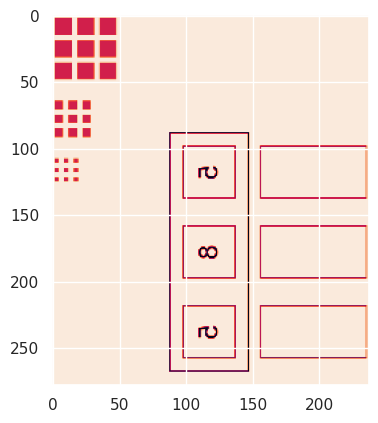

In [9]:
def policy(observation):
    return np.random.randint(0,6)

dbg=True
for _ in range(episodes):
    cumulative_reward,steps=0,0
    observation, info = env.reset(seed=42)
    cnt=0
    while True:
        action = policy(observation)  # User-defined policy function
        observation, reward, terminated, truncated, info = env.step(action)
        cumulative_reward+=reward
        steps+=1
        time.sleep(0.5)
        if dbg==True:
            print(f'cumulative_reward {cumulative_reward}; action {action}')
            print(observation["visual"].shape)
            output=U.crop(observation["visual"],scale_percent=40)
            print(output.shape)
            plt.imshow(output)
            plt.savefig('SuperReduced.png')
            output_=np.mean(output,axis=2)
            plt.imshow(output_)
            plt.savefig('BW.png')
            print(output_.shape)
            break
        if terminated or truncated:
            break
    print(f'Cumulative Reward ~ {cumulative_reward}; TimeTaken ~ {steps}')
env.close()

### Q-Learning w/o NLP. (NAIVE MODEL)

In [ ]:
num_actions=6
update_after_actions=2**8
update_target_network=2**13
frame_cnt,epsilon_greedy=0,100
episodes,mxSteps=2,50
episode_reward_hist,episode_avg_reward=[],[]
epsilon,epsilon_min,epsilon_max=1.0,0.005,1.0 
epsilon_interval = (
    epsilon_max - epsilon_min
) 
epsilon_greedy_frames = 100000.0
batch_size=2**10
action=-1
replay_mem={'state':[],'next_state':[],'action':[],'reward':[]}
mx_replay_memory=100000
gamma=0.9

# MODEL
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model=M.NNModel().to(device)
model_traget=M.NNModel().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.5)
epochs=20

for _ in range(episodes):
    episode_reward=0
    state, info = env.reset(seed=42)
    for __ in range(mxSteps):
        frame_cnt+=1
        epsilon -= epsilon_interval / epsilon_greedy_frames
        epsilon = max(epsilon, epsilon_min)
        if frame_cnt<=epsilon_greedy or epsilon>np.random.rand(1)[0]:
            action=np.random.choice(num_actions)
        else:
            action=np.argmax([model(state,a) for a in range(num_actions)])
        next_state,reward,terminated,truncated,info=env.step(action)
        episode_reward+=reward 
        replay_mem['state'].append(state)
        replay_mem['next_state'].append(next_state)
        replay_mem['action'].append(U.oneHot(num_actions,action))
        replay_mem['reward'].append(reward)
        state=next_state 
        if frame_cnt%update_after_actions==0 and len(replay_mem['reward'])>batch_size:
            choices=np.random.choice( range( len(replay_mem['reward']) ), size=batch_size )
            STATE=np.array([replay_mem['state'][id] for id in choices])
            NEXT_STATE=np.array([replay_mem['next_state'][id] for id in choices])
            ACTION=np.array([replay_mem['action'][id] for id in choices])
            REWARD=np.array([replay_mem['reward'][id] for id in choices])
            reward_true=REWARD+gamma*M.predict(model_traget,NEXT_STATE,num_actions)
            reward_pred=model(STATE,ACTION)
            for epoch in range(epochs):
                M.train(model,reward_pred,reward_true,STATE,NEXT_STATE,device,optimizer,epoch)
        if frame_cnt%update_target_network==0:
            model_traget.load_state_dict(model.state_dict())
        if len(replay_mem['reward'])>mx_replay_memory:
            del replay_mem['state'][:1]
            del replay_mem['next_state'][:1]
            del replay_mem['action'][:1]
            del replay_mem['reward'][:1]
        if terminated or truncated:
            break
    
    episode_reward_hist.append(episode_reward)
    episode_avg_reward.append(episode_reward/__)

# Save Relevant Results
np.save('results/ep_tot.npy',np.array(episode_reward_hist))
np.save('results/ep_avg.npy',np.array(episode_avg_reward))
torch.save(model.state_dict(),'results/model.ml')

In [ ]:
# Loading Results.
episode_reward_hist=np.load('results/ep_tot.npy')
episode_avg_reward=np.load('results/ep_avg.npy')
U.plot(episode_reward_hist,'Total Reward','Total Reward V/S Episodes')
U.plot(episode_avg_reward,'Avg. Reward','Avg. Reward Per Step V/S Episodes')
model_tr=M.NNModel().to(device)
model_tr.load_state_dict(torch.load('results/model.ml'))

### TBD

~~1. image training reduce.~~

~~2. save model_weights in File.~~

3. save replay memory in File.
4. check whether for all weights -> requries_grad=True
5. upload the code in google collab and make it train.
6. write instruction auto gen code. 